In [1]:
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators')
import matplotlib.pyplot as plt
import numpy as np
import utils.resonator_functions as rf
from shabanipy.jy_mpl_settings.colors import line_colors
from shabanipy.jy_mpl_settings.settings import jy_mpl_rc

root = '/Users/billystrickland/Documents/code/resonators/data/'
plt.style.use(jy_mpl_rc)

from scipy.optimize import curve_fit

import numpy as np
from scipy.special import kn, iv

kb = 8.617e-5         # Boltzmanns constant in units eV/Kelvin
h = 4.136e-15         # Plancks constant in units of eV s
    
def sigma1(T, d, f):
    return (4* d/(h * f)*np.exp(-d/kb/T)*np.sinh(h*f/2/kb/T))*kn(0,h*f/2/kb/T)

def sigma2(T, d, f):
    return (np.pi*d/(h*f)*(1-np.sqrt(2*np.pi*kb*T/d)*np.exp(-d/(kb*T))-2*np.exp(-d/(kb*T))*np.exp(-h*f/(2*kb*T))*iv(0, h*f/(2*kb*T))))

def phi(T, d, f):
    return np.arctan(sigma2(T, d, f)/sigma1(T, d, f))

def func_deltafoverf(T, a, d, f):
    # a is the kinetic inductance fraction
    return -a/2*(1-np.sin(phi(T, d, f))*np.sqrt((sigma1(T, d, f)**2+ sigma2(T, d, f)**2)/ ((sigma1(0.001, d, f)**2+ sigma2(0.001, d, f)**2))))

(<Figure size 576x288 with 1 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='$\\delta f_r/f_r (\\%)$'>)

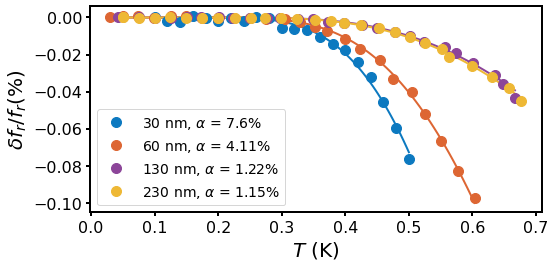

In [6]:
# List of file paths containing the CSV data for different resonator measurements.
FILES = [
    [root+'JS626-4SQ-v2-7-BSBHE-CD1/results/1131_tone=0_magnet=0_center=0.CSV'],
    [root+'JS681-6CLQ-004-BSLB-001/results/0204.csv'],
    [root+'JS681-6CLQ-003-BSLB-002/results/0062.csv'],
    [root+'JS681-6CLQ-005-BSLB-001/results/0124.csv']
]

# List of traces that correspond to different measurement samples (used for legend and labeling).
traces = ['30 nm', '60 nm', '130 nm', '230 nm']

# Function to create a combined plot of frequency shift (delta f) as a function of power
# FILES: List of file paths for measurement data
# traces: Labels for each trace (measurement), defaults to empty list
# mark: Boolean flag to determine if markers should be used on the plot, defaults to True
# print_results: Boolean flag to control printing the fitting results, defaults to True
def make_combined_plot_freq(FILES, traces = [''], mark = True, print_results = 'True'):
    # Label for the y-axis of the plot, representing relative frequency shift.
    y_label=r'$\delta f_r/f_r (\%)$'    

    # If 'mark' is True, assign a marker for each file in FILES
    if mark:
        markers = ['o' * len(marker_list) for marker_list in FILES]  # Create a list of markers for each dataset
    
    # Create the figure and axis for the plot with predefined labels, axis scales, and figure size.
    fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (8,4))
    
    # Loop over each file and its corresponding trace (measurement data)
    for i, f in enumerate(FILES):
        # Process the CSV file and extract results using a function 'rf.proc_csv' (not defined in the snippet)
        results = rf.proc_csv(f)

        # Get measurement data results from the processed CSV, including power, frequency, etc.
        photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 100000)
        
        # If it's not the first file, trim the last 5 elements from 'power' and 'freq' (likely for consistency)
        if i > 0:
            power, freq = power[0:-5], freq[0:-5]
        
        # Fit the frequency shift data (delta f/f) as a function of power using curve fitting
        # 'func_deltafoverf' is the function being fitted (not defined in the snippet)
        popt, pcov = curve_fit(func_deltafoverf, power, (np.array(freq) - (freq[0])) / freq,
                               p0=[.01, 210e-6, freq[0]],  # Initial guess for fitting parameters
                               bounds=([-np.inf, 0, freq[0] - .0000001], [np.inf, np.inf, freq[0] + .00001]),
                               maxfev=1000000000)  # Set the maximum number of function evaluations

        # Calculate the parameter errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))

        # Optionally print the fitting parameters (alpha, frequency shift, etc.)
        if print_results:
            print(popt)

        # Plot the error bars for delta f/f vs power, with each trace labeled by its corresponding sample
        ax.errorbar(np.array(power), (np.array(freq) - popt[2]) * 100 / freq,
                    linestyle='None',  # No line, only markers
                    color=line_colors[i],  # Color for the trace
                    marker=markers[i],  # Marker for the data points
                    label=traces[i] + r', $\alpha$ = ' + str(round(100 * popt[0], 2)) + '%')

        # Generate a smooth line to fit the data and plot it over the power range
        x = np.linspace(power[0], power[-1], 100)
        plt.plot(x, (func_deltafoverf(x, *popt)) * 100, color=line_colors[i])

        # Add the legend to the plot with a font size of 14
        plt.legend(fontsize=14)

        # Set the y-axis and x-axis limits for the plot for better visualization
        ylim = (-0.10515428457085638, 0.005992038948377484)
        xlim = (-0.0019559650000000005, 0.709274665)
        plt.ylim(ylim)
        plt.xlim(xlim)

        # Adjust the layout of the plot to avoid overlap and save the plot as a PDF
        fig.tight_layout()
        plt.savefig(f'deltaf_f_{i}.pdf', format='pdf')

    return fig, ax  # Return the figure and axis for further manipulation if needed

# Call the function to create the combined plot with the given file list and trace labels, 
# and prevent printing fitting results (print_results=False).
make_combined_plot_freq(FILES, traces=traces, print_results=False)


3481.2449698086834 577.1874857934249
[2.09364539e-04 3.45012389e+03 2.30244824e+00 8.30451354e+09]
12016.56573416812 775.0549141400782
[2.10371004e-04 1.17242601e+04 1.34506475e+01 7.80776932e+09]
23681.33234587186 1337.793528388672
[2.02109604e-04 2.37351179e+04 5.19339330e+01 8.01635480e+09]
31257.508007397453 1371.6302595447146
[2.05640517e-04 3.00638222e+04 5.86417626e+01 7.97160031e+09]


(<Figure size 576x288 with 1 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='$Q_\\mathrm{int}$'>)

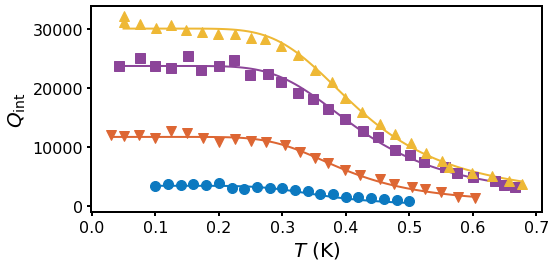

In [8]:
# List of file paths containing the CSV data for different resonator measurements.
FILES = [
    [root+'JS626-4SQ-v2-7-BSBHE-CD1/results/1131_tone=0_magnet=0_center=0.CSV'],
    [root+'JS681-6CLQ-004-BSLB-001/results/0204.csv'],
    [root+'JS681-6CLQ-003-BSLB-002/results/0062.csv'],
    [root+'JS681-6CLQ-005-BSLB-001/results/0124.csv']
]

# Define the function for calculating the internal quality factor (Q_int) based on the model
# T: Temperature (K)
# delta: Delta value (not well defined in the code)
# Qi: Intrinsic quality factor
# Q0: Initial quality factor (assumed to be a given parameter)
# f: Frequency (Hz)
def func_qint_qp(T, delta, Qi, Q0, f):
    kb = 8.617e-5  # Boltzmann constant in eV/K
    h = 4.136e-15  # Planck's constant in eV*s
    # Calculate Qqp using the provided formula
    Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))  # Qqp is a temperature-dependent function
    # Calculate Qint as the parallel combination of Qi and Qqp
    Qint = 1/(1/Qi + 1/(Qqp))
    return Qint

# Function to create a combined plot for Q_int (internal quality factor) versus power
# FILES: List of file paths for measurement data
def make_combined_plot_qi(FILES):
    y_label=r'$Q_\mathrm{int}$'  # Label for the y-axis (internal quality factor)
    
    # List of markers for plotting (one marker for each dataset)
    markers = ['o', 'v', 's', '^']
    
    # Traces corresponding to the measurement samples (used for labeling the plots)
    traces = ['30 nm', '30+30 nm', '30+100 nm', '30+200 nm']
    
    # Create the figure and axis for the plot with predefined labels, axis scales, and figure size.
    fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale='linear', figsize=(8, 4))
    
    # Loop over each file and its corresponding trace (measurement data)
    for i, f in enumerate(FILES):
        # Process the CSV file and extract results using a function 'rf.proc_csv' (not defined in the snippet)
        results = rf.proc_csv(f)

        # Get measurement data results from the processed CSV, including power, frequency, etc.
        photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 1000000)
        
        # Print the first values of qi_diacorr and its error for debugging or inspection
        print(qi_diacorr[0], qi_diacorr_err[0])
        
        # Set bounds for curve fitting; more constrained bounds for the second dataset (i == 1)
        bounds = ([200e-6, 0, 0, freq[0] - .0000001], [220e-6, np.inf, np.inf, freq[0] + .00001])
        if i == 1:
            bounds = ([210e-6, 0, 0, freq[0] - .0000001], [220e-6, np.inf, np.inf, freq[0] + .00001])
        
        # If not the first dataset, trim the last 5 elements from 'power' and 'qi_diacorr' (likely for consistency)
        if i > 0:
            power, qi_diacorr = power[0:-5], qi_diacorr[0:-5]
        
        # Fit the data to the func_qint_qp function using curve fitting
        popt, pcov = curve_fit(func_qint_qp, power, qi_diacorr,
                               p0=[210e-6, qi_diacorr[0], 1, freq[0]],  # Initial guess for the fitting parameters
                               bounds=bounds,  # Fitting bounds
                               maxfev=1000000000)  # Maximum number of function evaluations
        
        # Calculate the parameter errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        
        # Print the optimized parameters (Qint and related values) for inspection
        print(popt)
        
        # Plot the error bars for Q_int vs power, with each trace labeled by its corresponding sample
        ax.errorbar(np.array(power), qi_diacorr,
                    linestyle='None',  # No line, only markers
                    color=line_colors[i],  # Color for the trace
                    marker=markers[i])  # Marker for the data points

        # Generate a smooth line to fit the data and plot it over the power range
        x = np.linspace(power[0], power[-1], 100)
        plt.plot(x, func_qint_qp(x, *popt), color=line_colors[i])
    
    # Set the limits for the y-axis (Q_int range) and x-axis (power range)
    lims = [(-1038.6042365556982, 33829.66136424304),
            (-0.0019559650000000005, 0.709274665)]
    plt.ylim(lims[0])  # Set the y-axis limits
    plt.xlim(lims[1])  # Set the x-axis limits

    # Adjust the layout of the plot to avoid overlap and save the plot as a PDF
    fig.tight_layout()
    plt.savefig(f'qi_qp_{i}.pdf', format='pdf')
    
    return fig, ax  # Return the figure and axis for further manipulation if needed

# Call the function to create the combined plot with the given file list
make_combined_plot_qi(FILES)


[1.56345539e-03 1.91649021e-05] [0.000189097826916349, 6.180620646726914e-06]


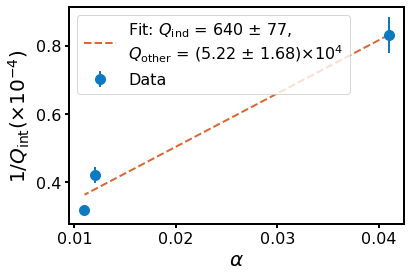

In [4]:
# Given arrays containing the measured values for Qi (internal quality factor), 
# the associated uncertainties (errors), and the alpha values for the resonators.
qis = np.array([12016.56573416812, 23681.33234587186, 31257.508007397453])
qis_err = np.array([775.0549141400782, 1337.793528388672, 1371.6302595447146])
alphas = np.array([4.1, 1.2, 1.1]) * 0.01  # Alpha values scaled by 0.01 for correct units

# Optionally, plot the data without fitting (this line is commented out).
# plt.plot(alphas, 1/qis, marker='o', linestyle='None')

# Define a linear model: y = m * x + b (a straight line with slope 'm' and intercept 'b')
def linear_model(x, m, b):
    return m * x + b

# Create a plot with specified figure size.
fig, ax = plt.subplots(figsize=(6, 4))

# Perform curve fitting (linear fit) on the inverse of Qi (1/Qi) against the alpha values.
# 'sigma' parameter corresponds to the uncertainties of 1/Qi (i.e., qis_err).
params, covariance = curve_fit(linear_model, alphas, 1/qis, sigma=qis_err)

# Extract the fitted slope (m) and intercept (b) from the fit parameters.
slope, intercept = params

# Calculate the errors (standard deviations) for the fitted parameters.
errors = [np.sqrt(covariance[0, 0]), np.sqrt(covariance[1, 1])]

# Print the fitted parameters and their associated errors for inspection.
print(params, errors)

# Calculate the fitted line values for the plot (y-values corresponding to the x-values 'alphas').
fitted_line = linear_model(alphas, *params)

# Plot the data points with error bars. The y-values are scaled by 1e4 for visualization.
# 'yerr' corresponds to the uncertainty in the y-values (1/Qi).
plt.errorbar(alphas, 1/qis * 1e4, yerr=qis_err / qis * 1/qis * 1e4, label='Data', linestyle='None', marker='o')

# Plot the fitted line (the result of the curve fitting) and display the fit equation in the legend.
# The slope and intercept values are used to format the legend.
plt.plot(alphas, fitted_line * 1e4, linestyle='--', label=f'Fit: $Q_\mathrm{{ind}}$ = {1/slope:1.0f} $\pm$ {errors[0]/slope * 1/slope:1.0f}' + 
         f',\n$Q_\mathrm{{other}}$ = ({1/intercept*1e-4:.2f} $\pm$ {errors[1]/intercept * 1/intercept*1e-4:.2f})' + r'$\times 10^{4}$')

# Set the y-axis label to indicate the units of 1/Q_int scaled by 10^(-4).
plt.ylabel(r'$1/Q_\mathrm{int} (\times 10^{-4})$')

# Set the x-axis label to represent the alpha values.
plt.xlabel(r'$\alpha$')

# Display the legend to show the data and the fit results.
plt.legend()

# Save the figure (the last line is commented out, so it won't execute unless uncommented).
# plt.savefig('fit_for_...')


[1.37029642e-03 1.18968476e-05] [0.004211426632246277, 5.59742801410647e-05]


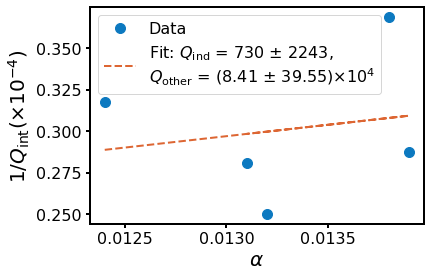

In [9]:
# Defining the array of Qi values (internal quality factors). 
# These values represent the inverse of the internal loss in resonators.
qis = np.array([
    31.5e3, 34.8e3, 27.1e3, 40e3, 35.6e3  # List of Qi values in units of 1e3
])

# Defining the corresponding array of alpha values. These values are scaled by 0.01.
# Alpha represents a characteristic parameter related to the resonators (e.g., strain or some material property).
alphas = np.array([
    1.24, 1.39, 1.38, 1.32, 1.31  # Alpha values in arbitrary units
]) * 0.01  # Scaling factor applied to alpha values (scaling by 0.01)

# Linear model function for fitting: y = m * x + b (a straight line with slope 'm' and intercept 'b').
def linear_model(x, m, b):
    return m * x + b

# Create a figure and axis for plotting.
fig, ax = plt.subplots(figsize=(6, 4))

# Perform the curve fitting with the linear model. 
# Fit the inverse of the Qi values (1/qis) as a function of alpha values.
# No explicit error values are provided, so we assume equally weighted points.
params, covariance = curve_fit(linear_model, alphas, 1/qis)

# Extract the fitted parameters (slope and intercept) from the result.
slope, intercept = params

# Calculate the errors (standard deviations) of the fitted parameters.
# Covariance matrix is used to calculate errors for each parameter.
errors = [np.sqrt(covariance[0, 0]), np.sqrt(covariance[1, 1])]

# Print the fitted parameters and their corresponding errors for inspection.
print(params, errors)

# Calculate the fitted line using the fitted parameters (slope and intercept).
fitted_line = linear_model(alphas, *params)

# Plot the data points (1/Qi vs. alpha) with markers (o) and no line connecting the points.
plt.plot(alphas, 1/qis * 1e4, label='Data', linestyle='None', marker='o')

# Plot the fitted line with the parameters obtained from the curve fitting.
# The fit equation and uncertainties in slope and intercept are displayed in the legend.
plt.plot(alphas, fitted_line * 1e4, linestyle='--', label=f'Fit: $Q_\mathrm{{ind}}$ = {1/slope:1.0f} $\pm$ {errors[0]/slope * 1/slope:1.0f}' + 
         f',\n$Q_\mathrm{{other}}$ = ({1/intercept*1e-4:.2f} $\pm$ {errors[1]/intercept * 1/intercept*1e-4:.2f})' + r'$\times 10^{4}$')

# Set the y-axis label to indicate the units of the inverse of the internal quality factor (scaled by 10^(-4)).
plt.ylabel(r'$1/Q_\mathrm{int} (\times 10^{-4})$')

# Set the x-axis label to represent the alpha values.
plt.xlabel(r'$\alpha$')

# Display the legend, which includes information about the data and the fitted model.
plt.legend()

# (Optional) Save the figure (line is commented out). Uncomment this to save the plot as a file.
# plt.savefig('fit_for_...')